In [1]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.neural_network import *
import xgboost as xgb
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, MissingIndicator
from statsmodels.tsa.statespace.sarimax import SARIMAX

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'


df = load_df()

def add_is_balanced(df):
    df["is_balanced"] = df["min_price_published"].isna() & df["max_price_published"].isna()
    return df

df = add_is_balanced(df)

df["residual_load"] = df["forecast_demand"] - df["forecast_solar"] - df["forecast_wind"]
df["dispatch_diff"] = df["upward_dispatch_published"] - df["downward_dispatch_published"]
df["igcc_diff"] = df["igcc_contribution_up_published"] - df["igcc_contribution_down_published"]

version = "target"
target = "fix_two_sided_ptu"
train_set = "train"
test_set = "valid"

count    16.000000
mean      0.008217
std       0.009842
min      -0.018337
25%       0.005560
50%       0.007890
75%       0.015926
max       0.020996
Name: 0, dtype: float64
count    16.000000
mean     -0.005391
std       0.013851
min      -0.037284
25%      -0.014890
50%      -0.002875
75%       0.003842
max       0.017114
Name: 1, dtype: float64
count    16.000000
mean     -0.005391
std       0.013851
min      -0.037284
25%      -0.014890
50%      -0.002875
75%       0.003842
max       0.017114
Name: 2, dtype: float64
0.02099551836033514


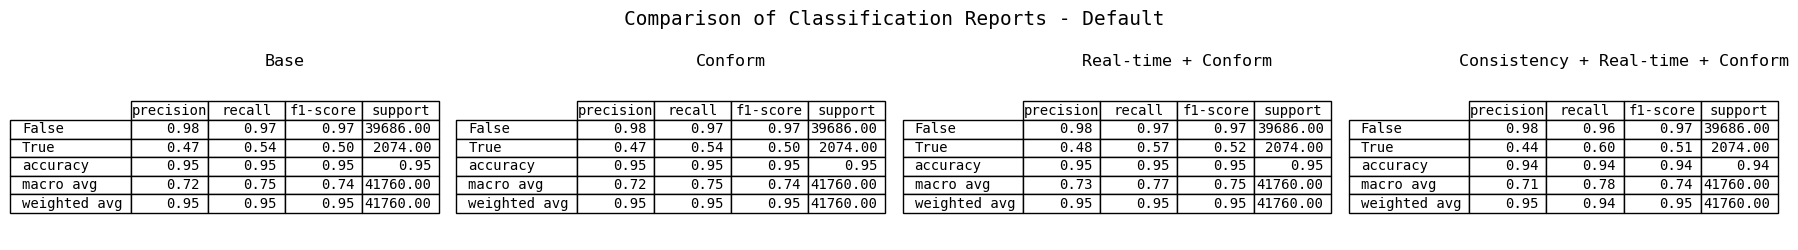

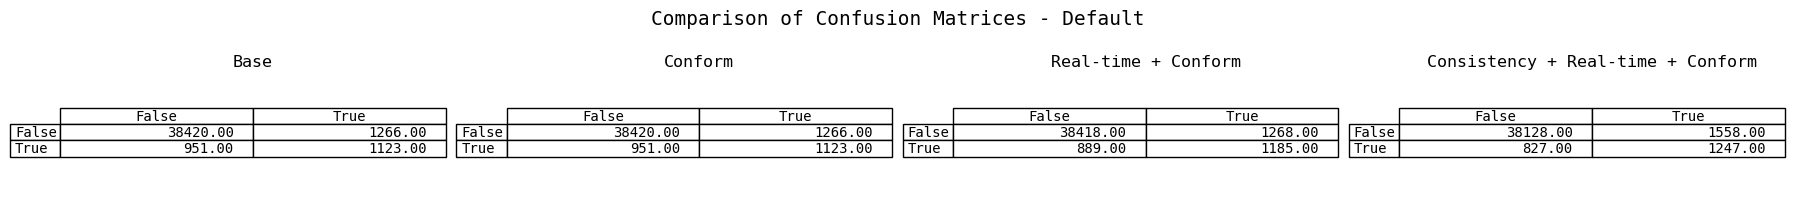

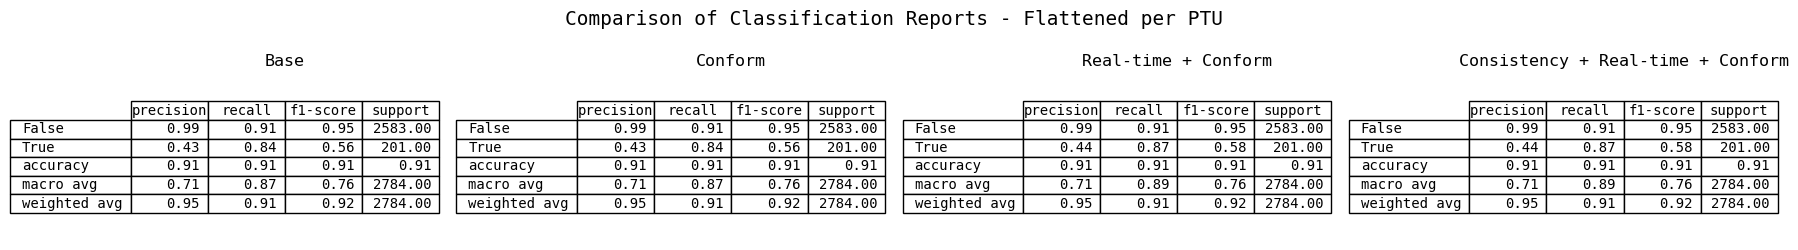

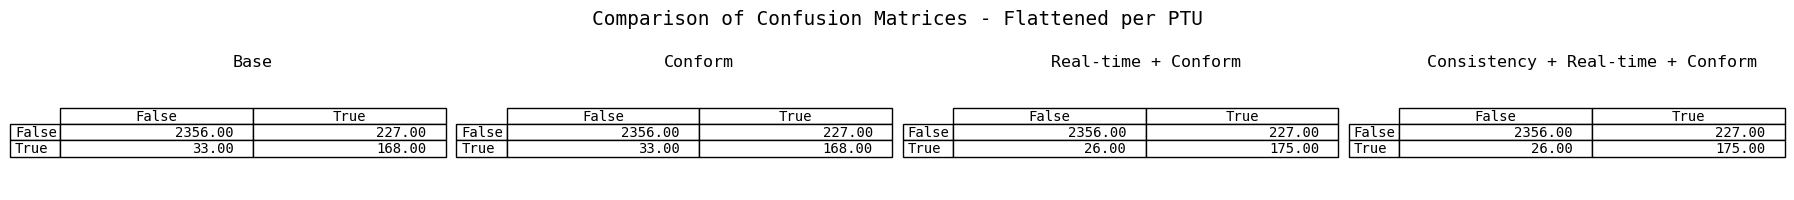

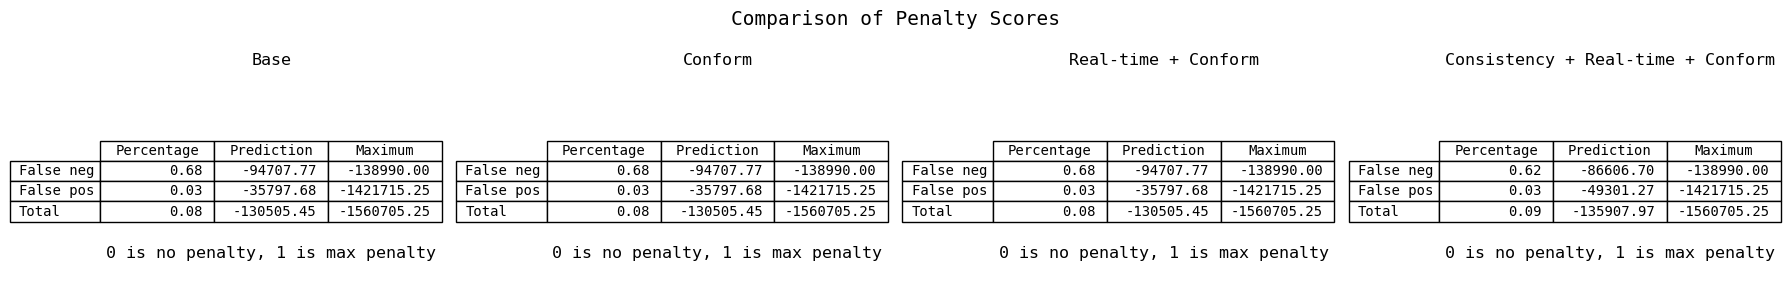

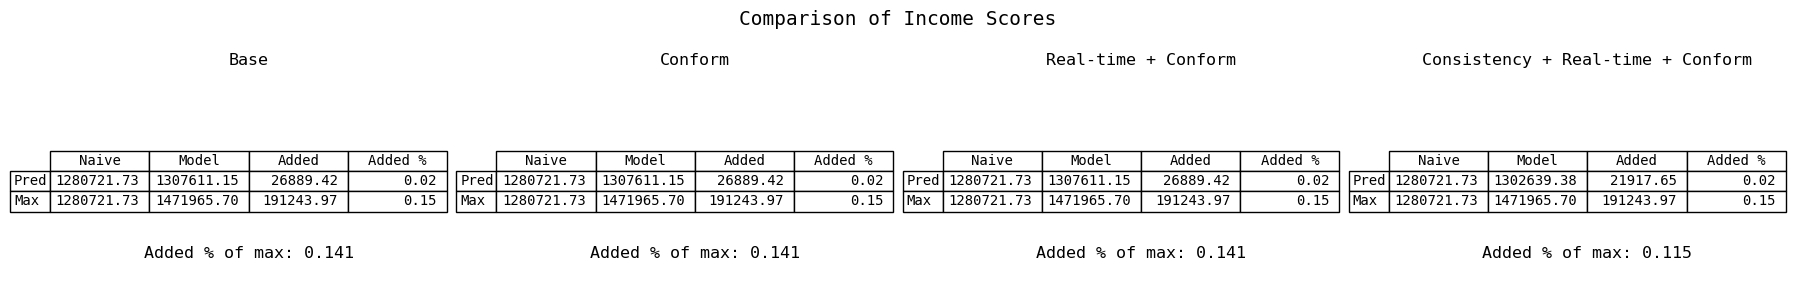

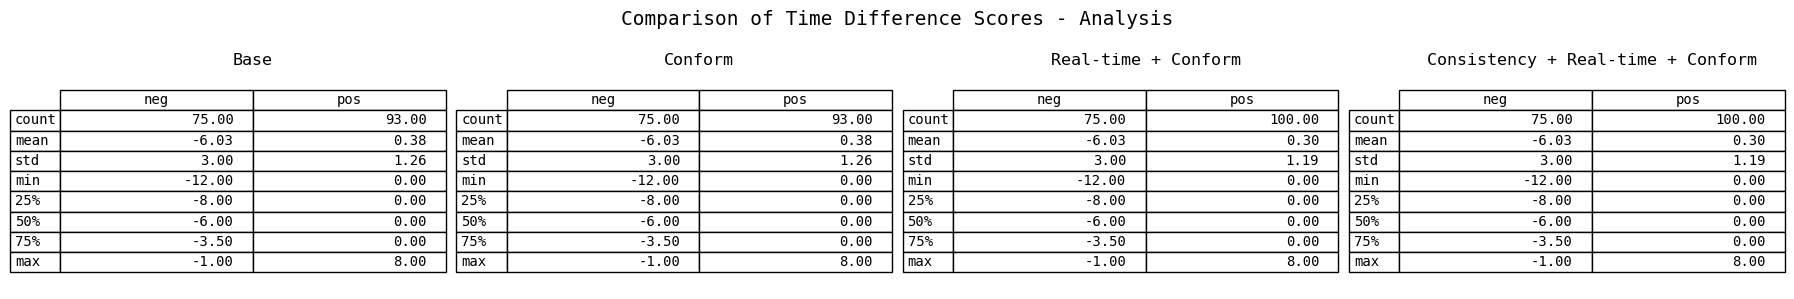

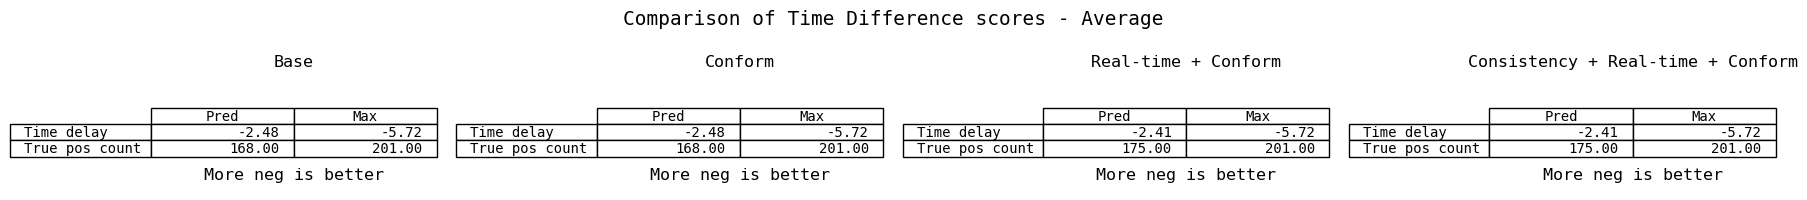

In [6]:
features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "min_ptu_price_known",
    "max_ptu_price_known",
    # "upward_dispatch_published",
    # "downward_dispatch_published",
    "time_since_last_two_sided",
    # "two_sided_daily_count",
    "PTU",
    # "naive_strategy_action",
    "vwap_avg",
    "vwap_std",
    "vwap_median",
    # "vwap_qty_sum",
    # "hvq_delta",
    # "forecast_wind",
    # "forecast_solar",
    # "forecast_demand",
    "target_two_sided_ptu_realtime",
    "residual_load",
    "dispatch_diff",
    "igcc_diff",
    "is_balanced"
]
splits = get_splits(df, features, target, return_dict_pair=False)


def train(train_in, train_out):
    # transformer = FeatureUnion(
    #     transformer_list=[
    #         ('features', IterativeImputer(initial_strategy="median")),
    #         ('indicators', MissingIndicator())])
    model = make_pipeline(
        # transformer,
        # IterativeImputer(sample_posterior=True, initial_strategy="mean", max_iter=100, skip_complete=True, add_indicator=True),
        # StandardScaler(),
        # SimpleImputer(),
        HistGradientBoostingRegressor(loss="poisson", l2_regularization=4, learning_rate=0.3, validation_fraction=0.2)
        # ExtraTreesRegressor(n_jobs=-1)
    )
    # model = HistGradientBoostingRegressor(loss="poisson", l2_regularization=8, learning_rate=0.2, validation_fraction=0.2)
    # model = xgb.XGBClassifier(objective="binary:hinge", subsample=0.9, tree_method="hist", grow_policy="lossguide", max_depth=8)
    # model = HistGradientBoostingClassifier(l2_regularization=8, learning_rate=0.3, validation_fraction=0.2, class_weight={0:1, 1:4})
    # model = SARIMAX(train_out, exog=train_in, order=(5, 1, 0))
    # model = RandomForestRegressor(n_estimators=200, criterion="poisson", max_features="log2", n_jobs=-1)
    # model = RandomForestClassifier(n_estimators=200, criterion="log_loss", max_features="log2", class_weight="balanced", n_jobs=-1)
    model = model.fit(train_in, train_out)
    
    return model


def test(model, test_in):
    # pred = model.forecast(steps=len(test_in), exog=test_in)
    pred = model.predict(test_in)
    return recast_pred(pred > 0.5)

# mask = splits[train_set][3].groupby("ptu_id")["naive_strategy_action"].transform("any")
# mask = splits[train_set][3]["naive_strategy_action"] | splits[train_set][3]["fix_two_sided_ptu"]
# splits[train_set][3]["neg"] = splits[train_set][3]["min_price_published"] < 0
# mask = splits[train_set][3].groupby("ptu_id")["neg"].transform("any")

best, _ = evaluate_income(train, test, splits[train_set][0], splits[train_set][1], splits[test_set][0], splits[test_set][3], repeat=16)

print(best[1])
p1 = test(best[0], splits[test_set][0])
show_metrics_adjusted(splits[test_set][3], p1, version=version)

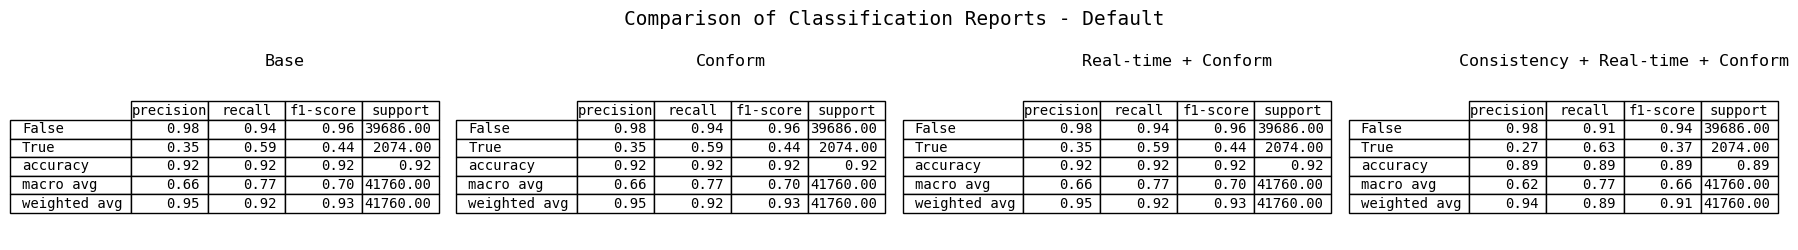

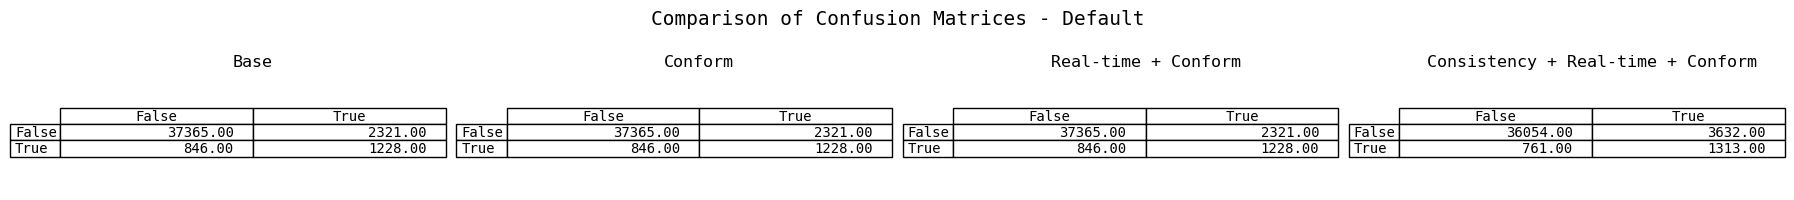

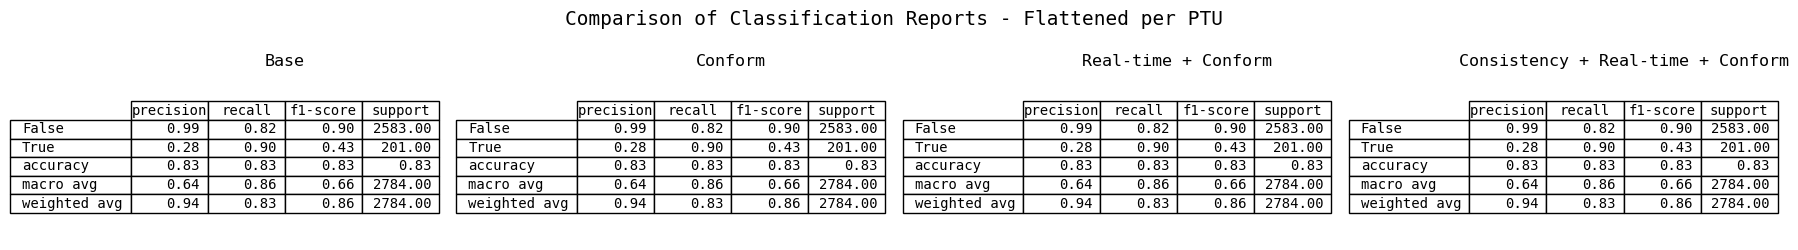

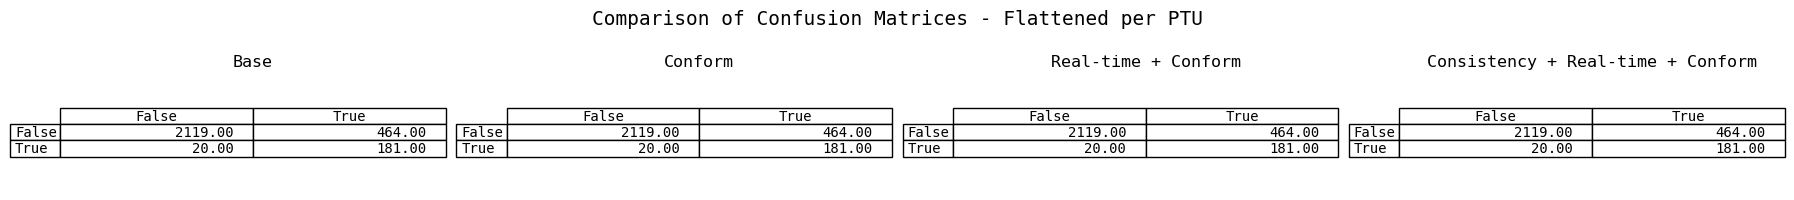

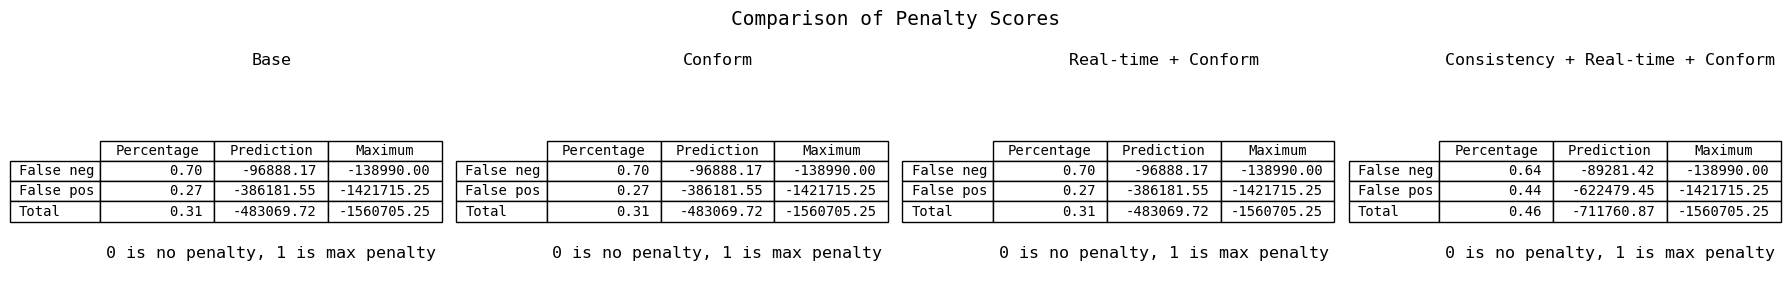

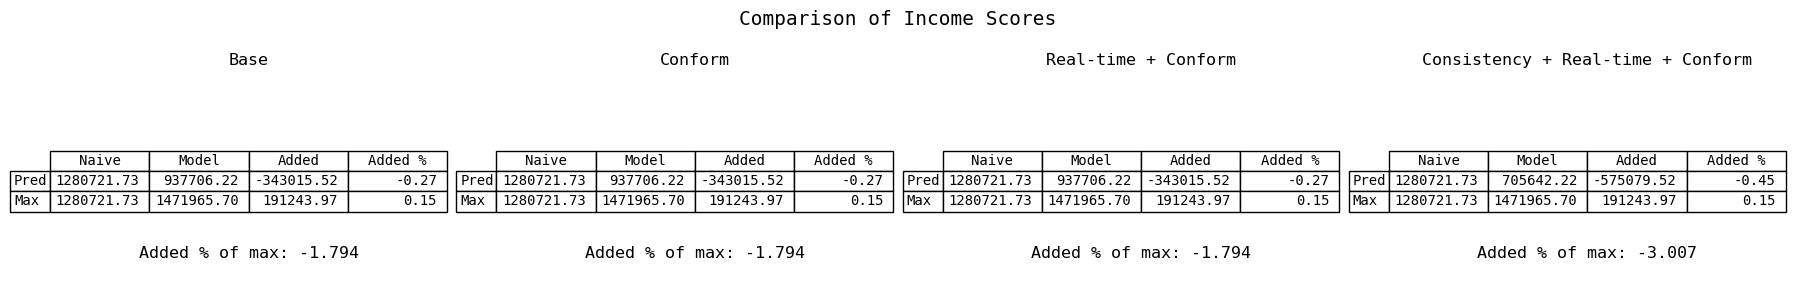

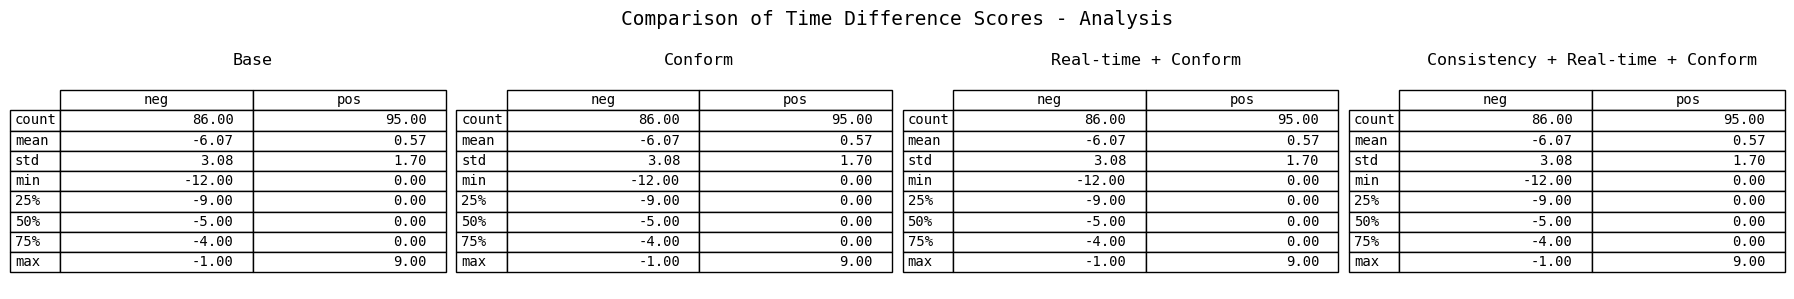

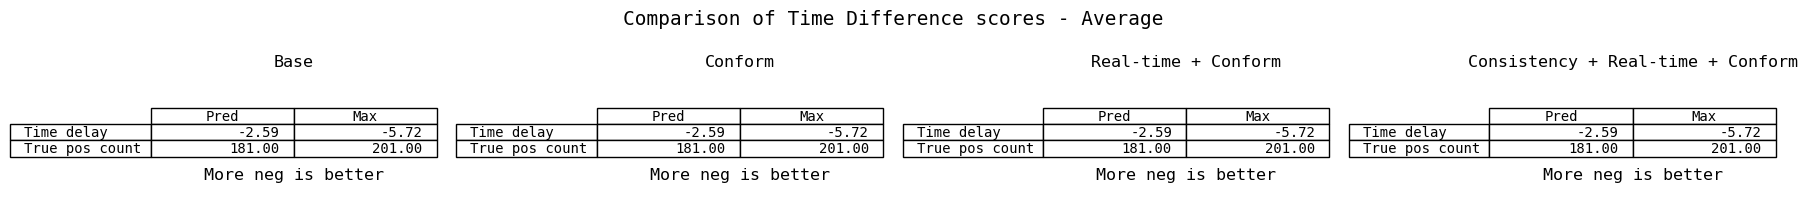

In [3]:
features = ["mid_price_published", "minute_in_ptu", "time_since_last_two_sided",
       "vwap_avg", "PTU", "forecast_demand", "ptu_id", "residual_load",
       "dispatch_diff", "igcc_diff"]
splits = get_splits(df, features, target, return_dict_pair=False)
# m = RandomForestClassifier(n_estimators=50)
# m = HistGradientBoostingRegressor(loss="poisson", l2_regularization=4)
m = HistGradientBoostingClassifier()
m.fit(splits[train_set][0], splits[train_set][1])
p = m.predict(splits[test_set][0])
# p = p > 0.5
p2 = recast_pred(p)
show_metrics_adjusted(splits[test_set][3], p2, version=version)

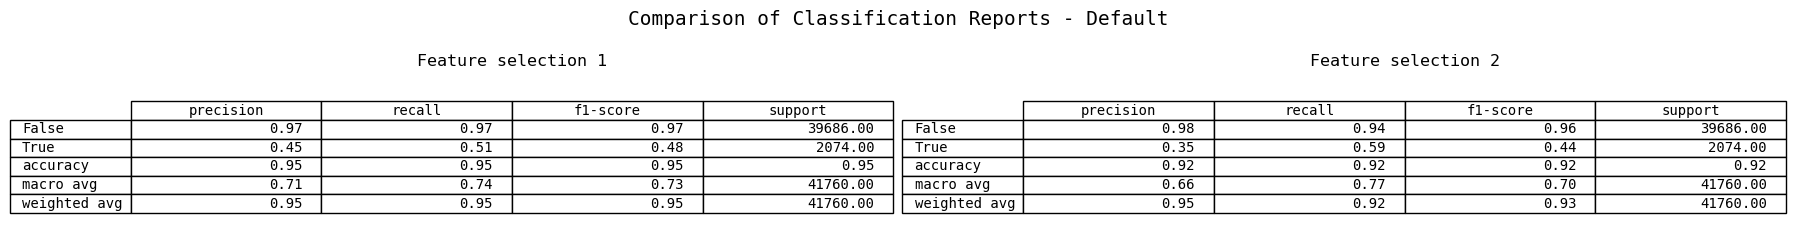

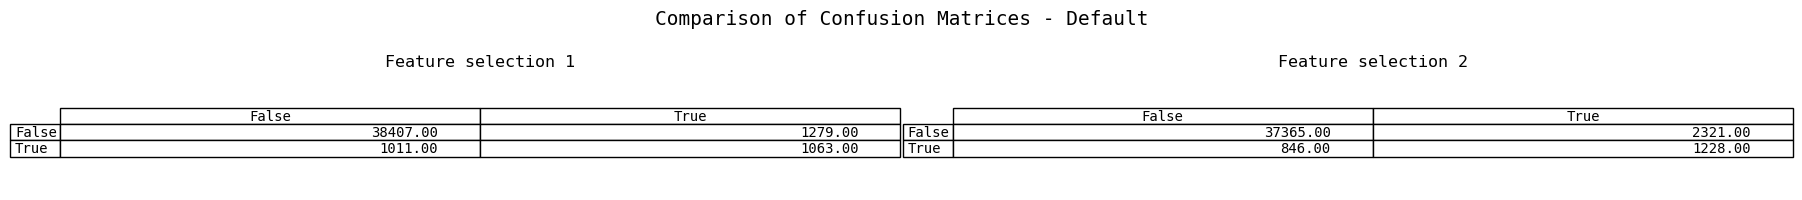

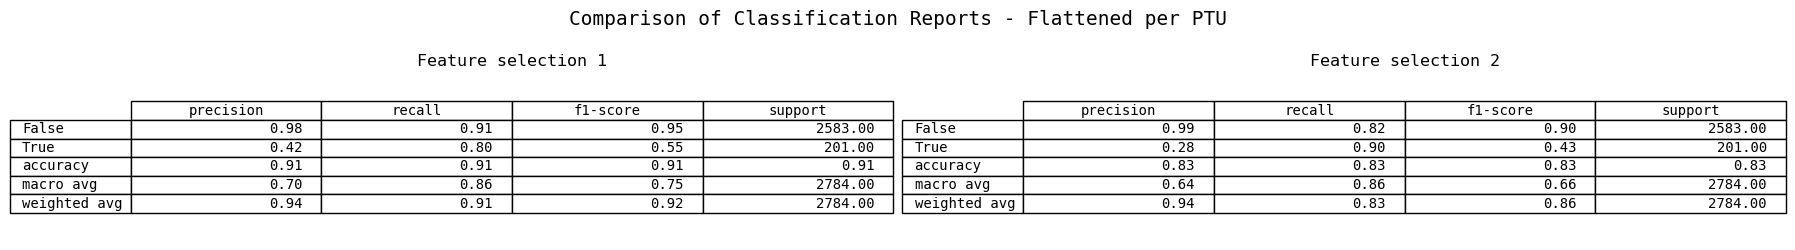

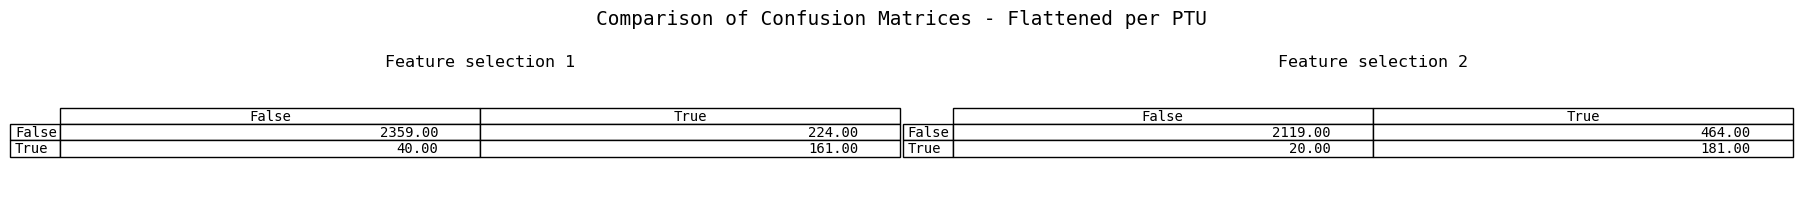

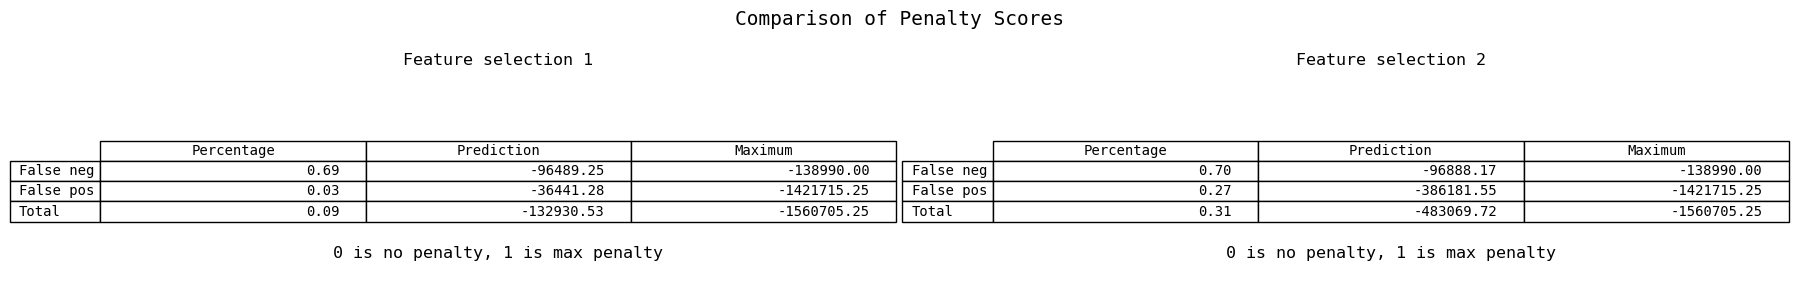

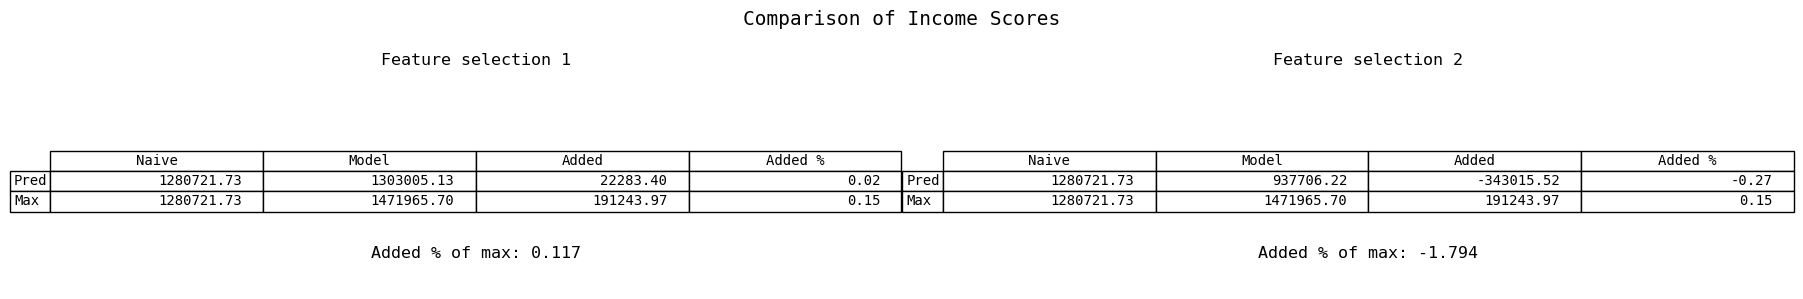

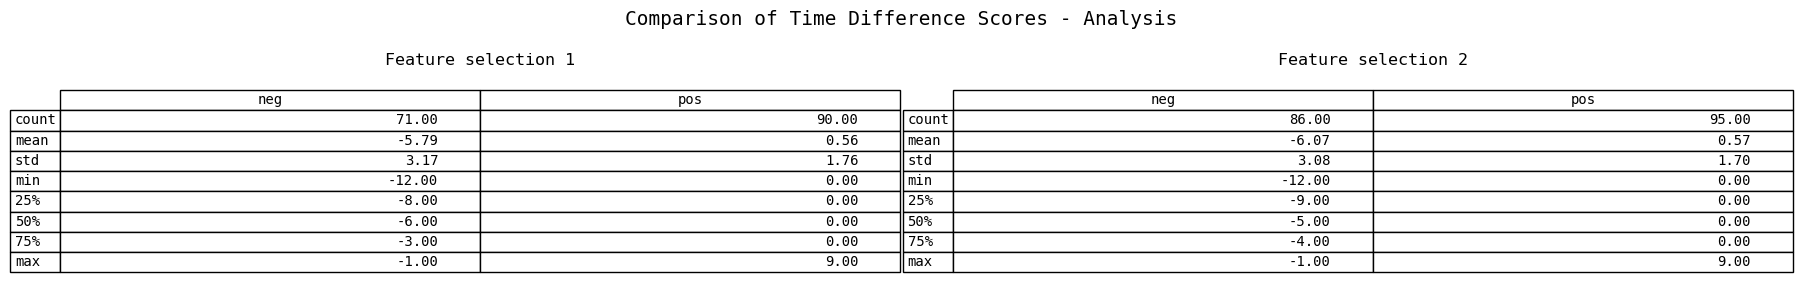

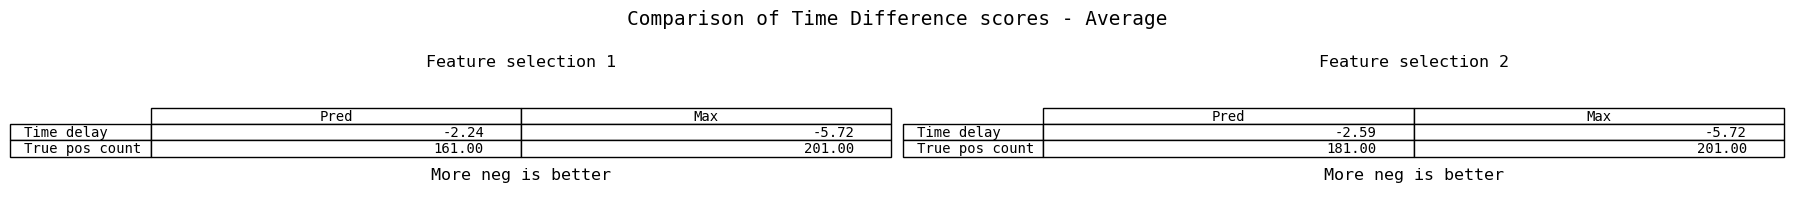

In [4]:
show_metrics_multi(splits[test_set][3], [p1, p2], titles=["Feature selection 1", "Feature selection 2"], version=version)